In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LassoCV, Lasso
import pingouin as pg


In [71]:
# (1) Load the CSV data 'one target' dataset
raw_data = pd.read_csv('data/testmybrain_clean_onetar_2March2023.csv')
raw_data = raw_data.sort_index(axis=1)
print(raw_data.columns)
print(pd.unique(raw_data['racialorigin']))

Index(['Age', 'Block', 'CCW', 'CN', 'ComputerUsage', 'FB', 'Group', 'HandFlip',
       'Hand_raw', 'Handedness', 'MT', 'NeuroDisease', 'NeuroDiseaseDescribe',
       'RT', 'ST', 'Sleep', 'StartTime', 'Subject.ID', 'TN', 'browsertype',
       'clumsy', 'education', 'endtime', 'gameIndex', 'major', 'mousetype',
       'numtar', 'racialorigin', 'rating', 'repeat.', 'ri', 'screenheight',
       'screenwidth', 'seedisplay', 'sex', 'technical', 'ti', 'videogames',
       'vision'],
      dtype='object')
['african-american' 'asian' 'white' 'rathernotsay' 'indian/native'
 'noneoftheabove' 'latinx' 'multiple' 'pacific-islander']


In [55]:
# (2) Preprocess data
df = raw_data.copy()

# CCW
df['CCW'] = df['CCW'].map({True:1, False : 0})

# Handedness
df['Handedness'] = df['Handedness'].map({'righth':'right', 'lefth':'left','bothh':'ambi'})

# Neurodisease
Neurodisease = {'No':0, ' ': 0, np.nan:0, 
               'AD':1, 'CD':1, 'MS':1,
               'Other':1, 'PD':1, 'Stroke':1}
df['NeuroDisease'] = df['NeuroDisease'].map(Neurodisease)

#clumsy
clumsiness = {'Strongly Disagree':-2, 'Disagree':-1, 'Neutral' :0,'Agree': 1, 'Strongly Agree': 2}
df['clumsy'] = df['clumsy'].map(clumsiness)

# education 
education = {
    'rathernotsay': 0, 'noneoftheabove': 0,
    'primaryschool': 1, 'middleschool': 2,
    'secondaryschool': 3, 'college': 4,
    'technicalschool': 4, 'bachelor': 5,
    'graduate': 6
}
 
df['education'] = df['education'].map(education)

# Mouse type
df['mousetype'] = df['mousetype'].replace({'idk': 'other','trackball': 'other'})

# rating 1-5
rating = {'1star':1, '2star':2, '3star':3, '4star':4, '5star':5}
df['rating'] = df['rating'].map(rating)

# screensize
df['screensize'] = df['screenwidth'] * df['screenheight']
df.drop(['screenwidth','screenheight'], axis=1, inplace=True)

# (F) cardinal -> 0/1
df['cardinal'] = df['ti'].apply(lambda x: 1 if x in [0, 90, 180, 270] else 0)

# videogames
df['videogames'] = df['videogames'].map(clumsiness)

# vision -> 
df['vision'] = df['vision'].apply(lambda x: 1 if str(x).lower() == 'yes' else 0)

# mov_avg (3-point moving average of HandFlip)
df['mov_avg'] = df['HandFlip'].rolling(window=3).mean()

# variability
df['variability'] = (df['mov_avg'] - df['HandFlip']).abs()



In [57]:
var = ['Age','browsertype','CCW','cardinal','clumsy','ComputerUsage','education','Handedness','NeuroDisease','major','mousetype',
       'rating','racialorigin',
       'sex','Sleep','screensize',
       'videogames','vision',
       'variability']
######### early adaptation
df_early = (df[
        (df['TN'] >= 31) &
        (df['TN'] <= 41)
                  ]
        .groupby(['Subject.ID'],as_index=False)
        .agg({
            **{c: 'mean' for c in ['HandFlip', 'MT','RT','ST']},
            **{c:'first' for c in var},
            })
        .dropna()
        )

####### late adaptation
df_late = (df[
        (df['TN'] >= 75) &
        (df['TN'] <= 84)
                  ]
        .groupby(['Subject.ID'],sort=False)
        .agg({
            **{c:'mean' for c in {'HandFlip', 'MT','RT','ST'}},
            **{c : 'first' for c in var},
        })
        .reset_index()  
        )


######## After effect
df_ae = (df[
        (df['TN'] >= 85) &
        (df['TN'] <= 90)
                  ]
        .groupby(['Subject.ID'],sort=False)
        .agg({
            **{c : 'mean' for c in {'HandFlip', 'MT','RT','ST'}},
            **{c : 'first' for c in var},
            }) 
        .reset_index()
        )


In [59]:
df_early = df_early.rename(columns = {'MT':'Movement_time_mean', 'RT':'Reaction_time_mean', 'ST':'Search_time_mean'})

In [61]:
# scale numerical variables
numerical_variables = ['HandFlip','Movement_time_mean',
                      'Reaction_time_mean','Search_time_mean','Age','clumsy','ComputerUsage',
                       'education','rating', 'screensize', 'Sleep','videogames']
scaler = StandardScaler()
df_early[numerical_variables] = scaler.fit_transform(df_early[numerical_variables])

# Convert categorical variables to dummy
var_categorical = ['Handedness','major','mousetype','racialorigin','sex']
df_early = pd.get_dummies(df_early, columns=var_categorical, drop_first = False)

In [26]:
df_early = df_early.drop(columns=['Subject.ID','browsertype'])
y = df_early['HandFlip']
X = df_early.drop(columns = 'HandFlip')

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size = 0.8,test_size = 0.2, random_state=42)

In [30]:
# fit lasso regression using 10 kfold cv
lasso_cv = LassoCV(cv=10)
lasso_model= lasso_cv.fit(X_train, y_train)
alpha_best = lasso_model.alpha_
print("Best alpha:", alpha_best)

Best alpha: 0.00596289527686826


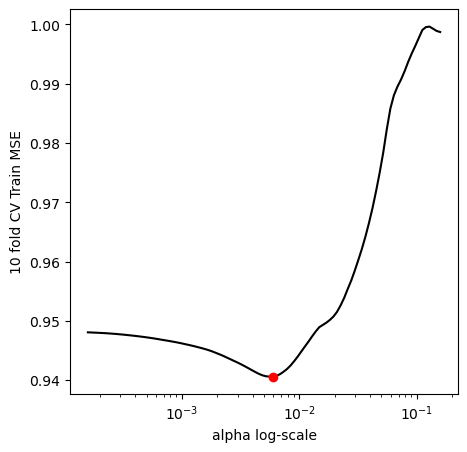

In [32]:
# The mse estimates are the mean aross folds (cols)
MSEs = np.mean(lasso_model.mse_path_, axis=1)

# Plot CV error vs alpha
fig, ax = plt.subplots(figsize=(5,5));
ax.plot(lasso_model.alphas_,MSEs, color='k');
ax.plot(alpha_best, np.min(MSEs), marker='o', color='r');
ax.set_xlabel('alpha log-scale');
ax.set_xscale('log')
ax.set_ylabel('10 fold CV Train MSE');


In [34]:

# test, first choose the best alpha and fit the model 
lasso_model_test = Lasso(alpha = alpha_best)
lasso_model_test.fit(X_train, y_train)
r2_scores = cross_val_score(lasso_model_test, X_train, y_train, cv = 10, scoring='r2')
r2_cv = r2_scores.mean()
print("Cross-validated R² (R2cv):", r2_cv)
y_predict = lasso_model_test.predict(X_test)
MSE_test = np.mean((y_predict - y_test)**2)
print(MSE_test) 

Cross-validated R² (R2cv): 0.05106275556701043
0.936352476919197


In [36]:
coefs = lasso_model_test.coef_
feature_names = X.columns  # Assuming X is a DataFrame
from sklearn.utils import resample

n_bootstraps = 1000
bootstrap_coefs = np.zeros((n_bootstraps, X_train.shape[1]))

for i in range(n_bootstraps):
    X_bs, y_bs = resample(X_train, y_train)
    model_bs = Lasso(alpha=alpha_best)
    model_bs.fit(X_bs, y_bs)
    bootstrap_coefs[i, :] = model_bs.coef_

coef_means = np.mean(bootstrap_coefs, axis=0)
coef_lowers = np.percentile(bootstrap_coefs, 2.5, axis=0)
coef_uppers = np.percentile(bootstrap_coefs, 97.5, axis=0)



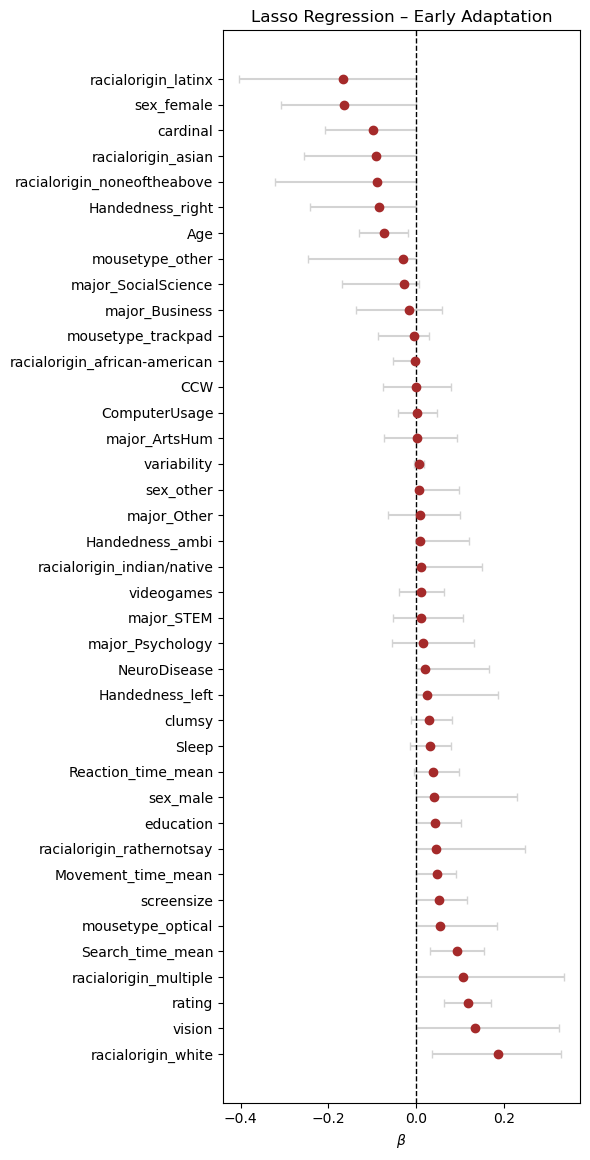

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Example inputs — replace with your actual data
feature_names = X.columns.tolist()  # or a list of your feature names
coef_means = np.mean(bootstrap_coefs, axis=0)
coef_lowers = np.percentile(bootstrap_coefs, 2.5, axis=0)
coef_uppers = np.percentile(bootstrap_coefs, 97.5, axis=0)

# Filter only non-zero coefficients (optional)
nonzero_mask = coef_means != 0
feature_names = np.array(feature_names)[nonzero_mask]
coef_means = coef_means[nonzero_mask]
coef_lowers = coef_lowers[nonzero_mask]
coef_uppers = coef_uppers[nonzero_mask]


# Ensure positive error bars
lower_err = np.maximum(coef_means - coef_lowers, 0)
upper_err = np.maximum(coef_uppers - coef_means, 0)
error = np.vstack((lower_err, upper_err))

# Sort by effect size (optional)
sort_idx = np.argsort(coef_means)
feature_names = feature_names[sort_idx]
coef_means = coef_means[sort_idx]
error = error[:, sort_idx]

# Plot
fig, ax = plt.subplots(figsize=(6, len(feature_names)*0.3))
ax.errorbar(coef_means, range(len(feature_names)), xerr=error, fmt='o', color='brown', ecolor='lightgray', capsize=3)
ax.axvline(0, color='black', linestyle='--', linewidth=1)

ax.set_yticks(range(len(feature_names)))
ax.set_yticklabels(feature_names)
ax.set_xlabel(r'$\beta$')
ax.set_title('Lasso Regression – Early Adaptation')
ax.invert_yaxis()  # top to bottom
plt.tight_layout()
plt.show()
